# 4.1 Neural Networks 

A linear regression is a single, fully connected neuron.

![Single Neuron](../img/TLU.png)
Figure: Extracted from "Hands on Maching Learning using Keras and Tensorflow"


The simplest neural network is a logistic regression

$y = f( \sum_{i=1}^3  (w_i x_i + b_i))$,

where $y$ is the output, $w_i$, are the weights, $b_i$ are the biases in the neuron, and $f$ is an activation function (e.g., sigmoid, ReLu, etc)

For classification problem, it is called a **Threshold Logic Unit** TLU because it outputs a linear combination of the inputs, and if the result exceeds a threshold, it outputs the positive class.

A perceptron is a single layer of TLUs, which each TLU connected to all the inputs. 

**Logistic regression: It is just a one layer neural network classifier**

We will explore the classification problem with NN.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt
import numpy as np

## 1.  Dataset in Pytorch

We will read a dataset and convert into a format readable by PyTorch. 

We have a dataset of images of digits (0 to 9). Each image is made of 8 * 8 pixels in grey scale. We start from the familiar ``sklearn`` digits data set, which provides images as arrays and labels as integers.

The data is first cast as an array and we will prepare it as a PyTorch ready data.

### 1.1 Load arrays

In [18]:
# load data set in memory
from sklearn.datasets import load_digits
digits = load_digits() # load data set
data,labels = digits["data"].copy(),digits["target"].copy() # copy data and target
data = data.astype(np.float32).reshape(-1,8,8) # reshape data on 8x8 grid
print(data.shape,labels.shape)

(1797, 8, 8) (1797,)


The data set has 1797  8 x 8 images.

Now that we have data and labels, we have to prepare the data sets so that it can be used in PyTorch. The main steps are:
* Wrap these into a Pytorch ``DataSet``, which will also convert the arrays into ``tensors``.
* Split between training and testing data using ``random_split`` pytorch function
* Then load the datasets with ``DataLoader``


### 1.2 Create a custom dataset class
PyTorch provides the ```Dataset``` class that you can use to create a custom dataset. You need to implement the __len__ and __getitem__ methods.

In [19]:
from torch.utils.data import Dataset

class CustomDataset(Dataset): # create custom dataset
    def __init__(self, data,labels): # initialize
        self.data = data 
        self.labels = labels 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]
        return torch.Tensor(sample_data),(sample_labels) # return data as a tensor


In [20]:
custom_dataset = CustomDataset(data, labels)

# Example iteration through the training DataLoader
for batch_data, batch_labels in custom_dataset:
    # Your training loop here
    print("Train Batch Data:", batch_data)
    print("Train Batch Labels:", batch_labels)
    break


Train Batch Data: tensor([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
        [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
        [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
        [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
        [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
        [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
        [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
        [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])
Train Batch Labels: 0


### 1.3 Random split training and testing


In [21]:
from torch.utils.data import random_split

# Determine the size of the training set
train_size = int(0.8 * len(custom_dataset)) # 80% of the data set
test_size = len(custom_dataset) - train_size # 20% of the data set

# Use random_split to create training and testing subsets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])


### 1.4 Create a DataLoader
Once you have your custom dataset, you can use a DataLoader to handle batching, shuffling, and other data loading functionalities.


In [22]:
from torch.utils.data import DataLoader


# Create a DataLoader
batch_size = 32  # Adjust according to your needs
shuffle = True   # Set to True if you want to shuffle the data
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

# Example iteration through the testing DataLoader
for batch_data, batch_labels in data_loader_test:
    # Your testing loop here
    print("Test Batch Data:", batch_data.shape)
    print("Test Batch Labels:", batch_labels.shape)
    break


Test Batch Data: torch.Size([32, 8, 8])
Test Batch Labels: torch.Size([32])


## 2. Design Model

The first neural networks we will create is a single neuron that takes the images as input and output the probability in each of the 10 classes.

In [7]:
# We create a subclass of neural networks: 
# #This one will just have one layer

class NN1(nn.Module): # NN1 inherits from nn.Module


    # this defines the arcitecture of the NN
    def __init__(self, size_img, num_classes):
        # Here we define all the functions that we will use during the forward part (data -> prediction)
        
        # super means that the model will inherit all of the methods
        super(NN1, self).__init__()

        self.flatten = nn.Flatten() # go from a 8*8 tensor to a 64*1 tensor
        self.size_img = size_img # number of pixels in an image
        self.layer1 = nn.Linear(size_img, num_classes) # y = wx + b with w = 10*64 (10 digits * 256 pixels)


    # this defines how the data passes through the layers
    def forward(self, x):
        x = self.flatten(x)    # go from a 8*8 tensor to a 64*1 tensor
        logits = self.layer1(x) # y = wx + b with w = 10*64 (10 digits * 256 pixels)
        return torch.sigmoid(logits) # apply sigmoid function to the output of the layer to get a probability

We now create a model of the class NN1.

In [8]:
model = NN1(8*8, 10)

In [9]:
print(model)

NN1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=64, out_features=10, bias=True)
)


## 3. Loss Function

For the binary classification, we had defined the logistic function or *sigmoid* function as,

$\hat{y} = \frac{1}{1 + e^{-z}}$,
 
as the probability function for a binary classifier.

The log loss function to minimize is:

$\mathcal{L} =  - (y \log \hat{y} + (1 - y) \log (1 - \hat{y})$ with $\hat{y} = \frac{1}{1 + e^{-z}}$.

We wanted to find all of the weights $w$ and biases $b$ such that $P(Y = y)$ is maximum, which is equivalent to minimizing the loss $\mathcal{L}$.

For a multi-class classification, $k$ being the class and $K$ the number of classes, the sigmoid function is extended to a *softmax function*,

$P(Y = k) = \frac{\exp(w_k x + b_k)}{\sum_{j = 1}^K \exp(w_j x + b_j)}$

Once we have found the values of the $w_k$ and $b_k$ for $k = 1 , \cdots , K$, we can compute the values of the $P(Y = k)$. We then look for which value of $k$ $P(Y = k)$ is maximal and we classify this sample as class $k$.


Similarly, we define the loss with $K$ classes:

$\mathcal{L} = - \sum_{k = 1}^K y_k \log \frac{\exp(w_k x + b_k)}{\sum_{j = 1}^K \exp(w_j x + b_j)}$. We have $y_k = 1$ if the true label associated with the sample $x$ is $k$, otherwise $y_k = 0$.

This is called the _cross-entropy loss_.

In [10]:
nn.CrossEntropyLoss()

CrossEntropyLoss()

## 4. Optimization

*Gradient descent* uses the entire data set to compute the gradient and find the optimal (minimum loss) solution. Effectively, the batch size is the entire data set.

*Mini batch gradient descent* uses batches of data to compute the gradient, find a solution, and moves to the next set of training data. The batch size is determined. The prediction on the training set is calculated for each sample in the batch, then averaged. Then the gradient is calculated.

*Stochastic gradient descent* uses one data sample to calculate the gradient, finds a solution, then take another training sample to go down the gradient. Effectively, the batch size is 1.

In this example, we will use stochastic gradient descent SGD.

Parameters to choose are:
* optimizer (gradient descent or others)
* learning rate (scale to jump with the gradient)

In [11]:
learning_rate=0.001

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## 5. Training

Parameters to choose are:
* **batch size**: this is the size of an individual training set used to estimate an average model prediction loss, after which a gradient will be calculated, and the model weights updated.
* **number of epochs**: this is the number of times the training goes over the *entire* data sets. If the training set is split into batches of size ``batch_size``, then at each **epoch**, the training will be performed over all batches. Models tend to be trained over multiple-to-many epochs (10,100,1000). 

Let us now define how to train the model. We will create a function for that.

In [12]:
def train(model, n_epochs, trainloader, testloader=None,learning_rate=0.001 ):

    # Define loss and optimization method
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        # Loop on samples in train set
        for data in trainloader:
            # Get the sample and modify the format for PyTorch
            inputs, labels = data[0], data[1]
            inputs = inputs.float()
            labels = labels.long()
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Propagate the loss backward
            loss.backward()
            # Update the gradients
            optimizer.step()
            # Add the value of the loss for this sample
            running_loss += loss.item()
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)

        # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad(): # Context-manager that disabled gradient calculation.
                # Loop on samples in test set
                for data in testloader:
                    # Get the sample and modify the format for PyTorch
                    inputs, labels = data[0], data[1]
                    inputs = inputs.float() 
                    labels = labels.long()
                    # Use model for sample in the test set
                    outputs = model(inputs)
                    # Compare predicted label and true label
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            # Save error at the end of each epochs
            accuracy_time[epoch] = 100 * correct / total
    
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
              (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # Save history of loss and test error
    if testloader is not None:
        return (loss_time, accuracy_time)
    else:
        return (loss_time)

In [13]:
# (loss, error) = train(model, 10,trainloader, testloader, learning_rate)
(loss, accuracy) = train(model, 100,data_loader_train, data_loader_test)

[Epoch 1] loss: 2.332 - accuracy: 18.333
[Epoch 2] loss: 2.302 - accuracy: 19.444
[Epoch 3] loss: 2.273 - accuracy: 19.167
[Epoch 4] loss: 2.245 - accuracy: 19.722
[Epoch 5] loss: 2.214 - accuracy: 17.500
[Epoch 6] loss: 2.182 - accuracy: 16.944
[Epoch 7] loss: 2.153 - accuracy: 19.167
[Epoch 8] loss: 2.126 - accuracy: 21.944
[Epoch 9] loss: 2.102 - accuracy: 23.611
[Epoch 10] loss: 2.080 - accuracy: 25.278
[Epoch 11] loss: 2.059 - accuracy: 30.000
[Epoch 12] loss: 2.039 - accuracy: 33.056
[Epoch 13] loss: 2.021 - accuracy: 36.667
[Epoch 14] loss: 2.004 - accuracy: 40.000
[Epoch 15] loss: 1.988 - accuracy: 42.222
[Epoch 16] loss: 1.973 - accuracy: 45.278
[Epoch 17] loss: 1.959 - accuracy: 47.778
[Epoch 18] loss: 1.946 - accuracy: 50.000
[Epoch 19] loss: 1.934 - accuracy: 53.056
[Epoch 20] loss: 1.923 - accuracy: 55.556
[Epoch 21] loss: 1.912 - accuracy: 57.778
[Epoch 22] loss: 1.903 - accuracy: 59.722
[Epoch 23] loss: 1.894 - accuracy: 62.222
[Epoch 24] loss: 1.886 - accuracy: 63.333
[

Let us now plot the evolution of the loss and the percentage of correct predictions with time:

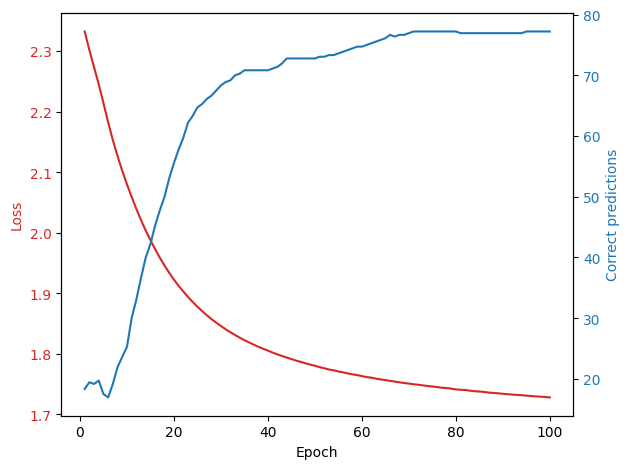

In [14]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 101), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 101), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()